**Classifying CIFAR10 images using Resnet **


**Team members:**

SAI RAM PURIMETLA

SHREYAS

HEMANTH MEKA


 **Importing the necessary libraries**

In [7]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from torchsummary import summary

# **Preparing the Dataset**

# **Dataset Preprocessing Steps**

**Data Extraction and Loading:**

The CIFAR-10 dataset is downloaded directly from Kaggle using the kagglehub library. After logging in to KaggleHub, the dataset is fetched by specifying the competition name deep-learning-spring-2025-project-1, and confirms successful data import by printing the download path.

**Data Reshaping and Normalization:**
The CIFAR-10 images are reshaped from 1D arrays into 3-channel 32x32 images. Pixel values are normalized using the CIFAR-10 mean (0.4914, 0.4822, 0.4465) and standard deviation (0.247, 0.243, 0.261).

**Dataset Preparation and Augmentation:**
Training data undergoes several augmentations, including random rotation, color jitter, horizontal flip, random cropping, and random erasing. The data is then converted into a TensorDataset and loaded using DataLoader for efficient batching. Validation data is normalized similarly but without augmentations.

In [18]:
import kagglehub
login = kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [19]:
deep_learning_spring_2025_project_1_path = kagglehub.competition_download('deep-learning-spring-2025-project-1')

100%|██████████| 189M/189M [00:09<00:00, 20.9MB/s]

Extracting files...


# Automatically choose CPU or GPU

In [20]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**The below code loads the CIFAR-10 dataset, applies data augmentation and normalization transformations to the training and validation images, and then prepares the data for training by creating custom datasets and loading them into data loaders for efficient batch processing.**

In [22]:
# Function to load a single batch of CIFAR-10 dataset
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')  # Load the batch using pickle
    return dict

# Specify the directory containing CIFAR-10 batches
cifar10_dir = str(deep_learning_spring_2025_project_1_path)+'/cifar-10-python/cifar-10-batches-py'

# Load metadata (labels) for the CIFAR-10 dataset
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]  # Decode label names from bytes

# Load training data from the first 5 batches
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))  # Load each batch
    train_data.append(batch[b'data'])  # Append image data
    train_labels += batch[b'labels']  # Append labels

# Reshape and transpose the training data to HWC format (Height, Width, Channels)
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)  # Convert labels to numpy array

# Data augmentation and normalization transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly change brightness, contrast, and saturation
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop images with padding
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  # Normalize images with mean and std
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value=1.0, inplace=False)  # Randomly erase parts of the image
])

# Custom dataset class for CIFAR-10
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # Store images
        self.labels = labels  # Store labels
        self.transform = transform  # Store transformations

    def __len__(self):
        return len(self.images)  # Return the number of images

    def __getitem__(self, idx):
        img = self.images[idx]  # Get image at index
        label = self.labels[idx]  # Get corresponding label

        if self.transform:
            img = self.transform(img)  # Apply transformations if any

        return img, label  # Return transformed image and label

# Create training dataset
train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)

# Load validation data from the test batch
batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape and transpose validation images
val_labels = np.array(batch_test_dict[b'labels'])  # Convert validation labels to numpy array

# Create validation dataset
val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=transform)

# Create DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)  # Training DataLoader
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)  # Validation DataLoader

# **Below is CustomResNet Block  with CustomResNet with Total params: 2,760,490**

In [27]:
# Define a single block of the Custom Wide Residual Network
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(CustomResNetBlock, self).__init__()
        # First convolutional layer with batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Skip connection for residual learning
        self.skip = nn.Sequential()
        # If the input and output dimensions do not match, apply a 1x1 convolution
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Store the identity for the skip connection
        identity = self.skip(x) if self.skip else x
        # Forward pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Forward pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        # Add the skip connection
        out += identity
        out = self.relu(out)
        return out

# Define the Custom WideResNet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        # Initial convolutional layer
        self.init_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        # Create layers of the network
        self.layer1 = self._make_layer(32, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        # Adaptive average pooling layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Fully connected layer for classification
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        # Create a sequence of CustomResNet blocks
        layers = [CustomResNetBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(CustomResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial layers
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        # Forward pass through the residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Pooling and flattening the output
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        # Final classification
        out = self.fc(out)
        return out

# Instantiate the model and move it to the specified device
model = CustomResNet().to(device)
# Print the model summary for a given input shape
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          18,432
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
CustomResNetBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [34]:

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
learning_rates = []


# Initialize lists to store training and validation losses, accuracies, and learning rates for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
learning_rates = []

def train_model(model, train_loader, val_loader, epochs=50, min_delta=0.001):
    # Define the loss function with label smoothing to improve generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    # Use SGD optimizer with momentum and weight decay for better convergence
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    # Cosine Annealing Learning Rate Scheduler to adjust the learning rate over epochs
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # Initialize variables to track the best validation loss and early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Main training loop for the specified number of epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        # Iterate over the training data loader
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move images and labels to the specified device (e.g., GPU or CPU)
            images, labels = images.to(device), labels.to(device)
            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()
            # Forward pass: compute model predictions
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            # Backward pass: compute gradients
            loss.backward()
            # Update model parameters
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()
            # Compute the number of correct predictions
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            # Update the total number of training samples
            total_train += labels.size(0)

            # Log the learning rate for each batch
            learning_rates.append(optimizer.param_groups[0]['lr'])

        # Calculate training accuracy for the epoch
        train_accuracy = 100 * correct_train / total_train
        # Store the average training loss and accuracy for the epoch
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation phase: evaluate the model on the validation set
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():  # Disable gradient computation for validation
            for images, labels in val_loader:
                # Move images and labels to the specified device
                images, labels = images.to(device), labels.to(device)
                # Forward pass: compute model predictions
                outputs = model(images)
                # Compute the loss
                loss = criterion(outputs, labels)
                # Accumulate validation loss
                val_loss += loss.item()
                # Compute the number of correct predictions
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(labels).sum().item()
                # Update the total number of validation samples
                total_val += labels.size(0)

        # Calculate validation accuracy for the epoch
        val_accuracy = 100 * correct_val / total_val
        # Store the average validation loss and accuracy for the epoch
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        # Update the learning rate using the scheduler
        scheduler.step()

        # Print training and validation metrics for the current epoch
        print(f"Epoch {epoch+1}:")
        print(f"    Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")
        print(f"    Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")



# Start training with plots
# Instantiate the model and move it to the specified device
model = CustomResNet().to(device)
train_model(model, train_loader, val_loader, epochs=100, min_delta=0.001)

Epoch 1:
    Train Loss: 1.8222, Train Accuracy: 38.00%
    Val Loss: 1.7177, Val Accuracy: 42.26%
Epoch 2:
    Train Loss: 1.4562, Train Accuracy: 56.23%
    Val Loss: 1.4668, Val Accuracy: 54.86%
Epoch 3:
    Train Loss: 1.2821, Train Accuracy: 65.33%
    Val Loss: 1.5676, Val Accuracy: 53.95%
Epoch 4:
    Train Loss: 1.1771, Train Accuracy: 70.44%
    Val Loss: 1.2275, Val Accuracy: 68.02%
Epoch 5:
    Train Loss: 1.0872, Train Accuracy: 74.69%
    Val Loss: 1.2242, Val Accuracy: 68.43%
Epoch 6:
    Train Loss: 1.0270, Train Accuracy: 77.27%
    Val Loss: 1.1819, Val Accuracy: 70.88%
Epoch 7:
    Train Loss: 0.9872, Train Accuracy: 79.54%
    Val Loss: 1.0891, Val Accuracy: 74.41%
Epoch 8:
    Train Loss: 0.9484, Train Accuracy: 81.10%
    Val Loss: 1.1875, Val Accuracy: 69.77%
Epoch 9:
    Train Loss: 0.9149, Train Accuracy: 82.62%
    Val Loss: 1.1395, Val Accuracy: 72.21%
Epoch 10:
    Train Loss: 0.8931, Train Accuracy: 83.49%
    Val Loss: 1.1073, Val Accuracy: 74.24%
Epoch 11:

# FINAL Validation ACCURACY: 93.89

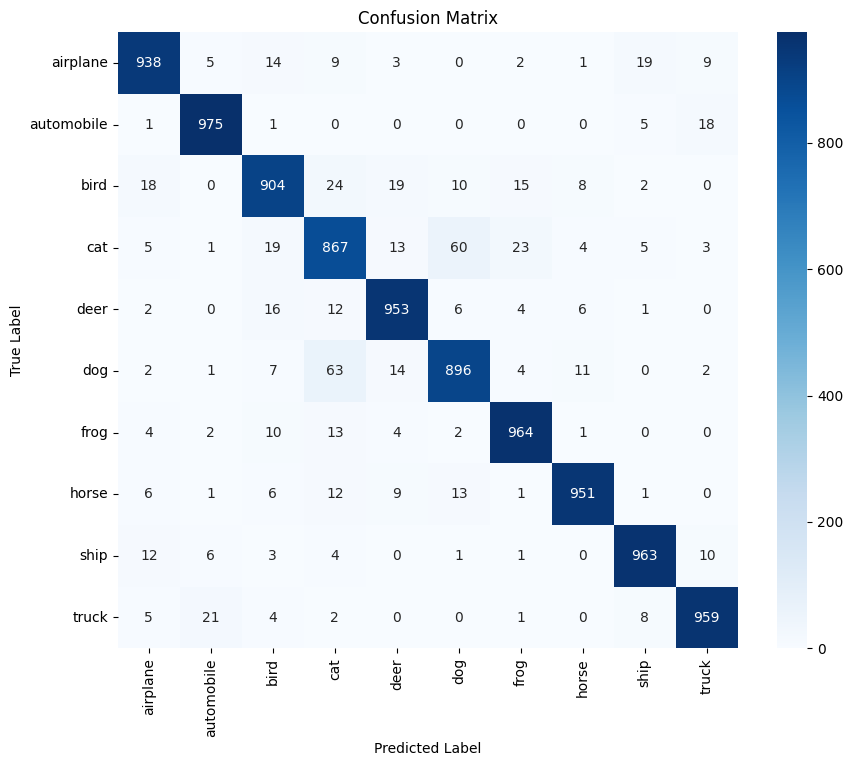

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, label_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, val_loader, label_names)

#### Plotting Loss vs Epochs. #####

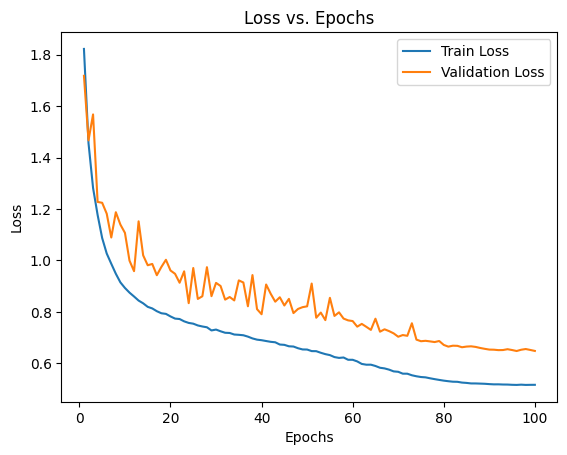

In [50]:
#### Plotting Loss vs Epochs. #####
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, learning_rates):
    epochs = range(1, len(train_losses) + 1)
    batches = range(1, len(learning_rates) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)

 # Plot Accuracy vs. Epochs

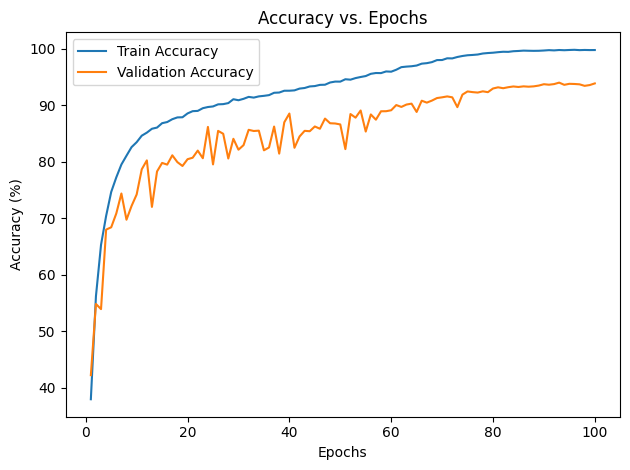

In [46]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, learning_rates):
    epochs = range(1, len(train_losses) + 1)
    batches = range(1, len(learning_rates) + 1)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)

# The Below code is used to run the above trained model on cifar_test_nolabel.pkl and predict the test labels and save the predicted labels in submission.csv

In [51]:
model.eval()
predictions4 = []
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
cifar_test_path = '/root/.cache/kagglehub/competitions/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0

# Convert test dataset to Tensor
test_dataset = [(test_transform(img),) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)  # Get images tensor from tuple and move to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions4.extend(predicted.cpu().numpy())

# Generate submission file
submission4 = pd.DataFrame({'ID': np.arange(len(predictions4)), 'Labels': predictions4})
submission4.to_csv('submission.csv', index=False)
print("Submission file saved.")

Submission file saved.


# Save the model

In [52]:
torch.save(model.state_dict(), "model_weights.pth")
from google.colab import files
files.download('model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>